In [105]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq
from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils
from IPython.display import Image, display
import matplotlib.image as mpimg
import io
from evaluation_metrics import evaluate_graph
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling

## ASIA DATASET

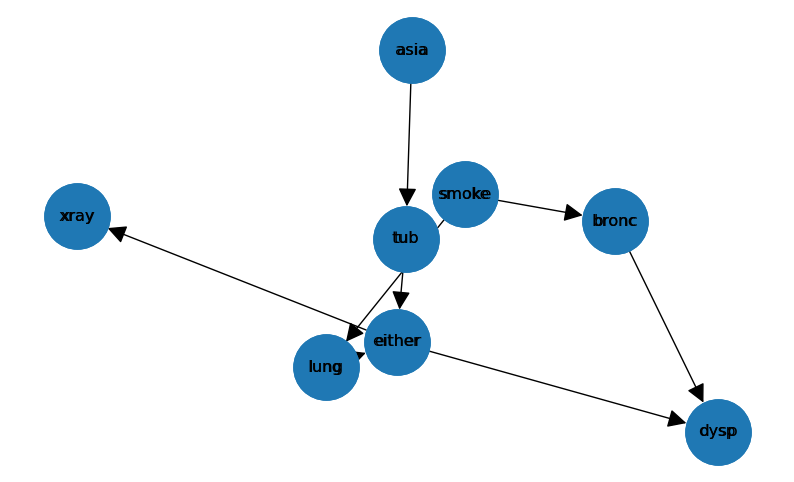

In [106]:
#Ground Truth Asia DAG
gt_nodes = ["asia", "smoke", "tub", "lung", "bronc", "either", "xray", "dysp"]

gt_edges = [("asia",  "tub"),
            ("smoke", "lung"),
            ("smoke", "bronc"),
            ("tub",   "either"),
            ("lung",  "either"),
            ("either","xray"),
            ("either","dysp"),
            ("bronc", "dysp")]

GT = nx.DiGraph()
GT.add_nodes_from(gt_nodes)
GT.add_edges_from(gt_edges)

# fixed layout so it looks the same every run
pos = nx.spring_layout(GT, seed=1000)

plt.figure(figsize=(10, 6))

nx.draw_networkx_nodes(GT, pos, node_size=2200)
nx.draw_networkx_labels(GT, pos, font_size=11)

# draw directed edges with arrowheads
nx.draw(GT, pos,
        with_labels=True,
        node_size=2200,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=28)
plt.axis("off")
plt.show()



In [107]:
# PC fitting on asia dataset


path = "asia.csv"
df = pd.read_csv(path)

# making sure that the the nodes are labelled 
col_map = {
    "A": "asia",
    "S": "smoke",
    "T": "tub",
    "L": "lung",
    "B": "bronc",
    "E": "either",
    "X": "xray",
    "D": "dysp",
}

df = df.rename(columns=col_map)


df =  df.replace({"yes": 1, "no": 0})



# trying multiple sample sizes for different PC models
sample_sizes = [500,2500,5000]



cgs_models = []


for sample_size in sample_sizes:
    


    df_subset = df.sample(n=sample_size, random_state=42).copy()


    # # Convert yes/no → 0/1
    # for c in df.columns:
    #     df_subset[c] = pd.Categorical(df_subset[c]).codes # more effective way

    X = df_subset.to_numpy().astype(int)


    cg = pc(data=X,
            alpha=0.05,
            indep_test=chisq,
            stable=True,
            uc_rule=0,
            verbose=False,
            node_names = df.columns.tolist())
    

    cgs_models.append(cg)

C:\Users\nikit\AppData\Local\Temp\ipykernel_17696\650918675.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df =  df.replace({"yes": 1, "no": 0})


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0 -1  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0]
 [-1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0 -1  0  0  0  0  0 -1]
 [ 0  0  0 -1  0  0 -1  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0  0  0  0 -1  0  0  0]]
Green: undirected; Blue: directed; Red: bi-directed



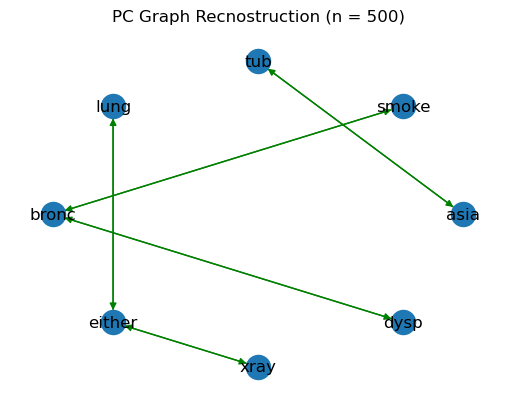


PC vs Ground Truth (Asia)
Adjacency precision: 1.000  (correct 5 / predicted 5)
Adjacency recall:    0.625  (correct 5 / true 8)
Arrowhead precision: 0.000  (correct 0 / predicted 0)
Arrowhead recall:    0.000  (correct 0 / true 8)
[[ 0  0 -1  0  0  0  0  0]
 [ 0  0  0 -1 -1  0  0  0]
 [ 1  0  0  0  0  1  0  0]
 [ 0 -1  0  0  0 -1  0  0]
 [ 0 -1  0  0  0  0  0 -1]
 [ 0  0 -1 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0]]
Green: undirected; Blue: directed; Red: bi-directed



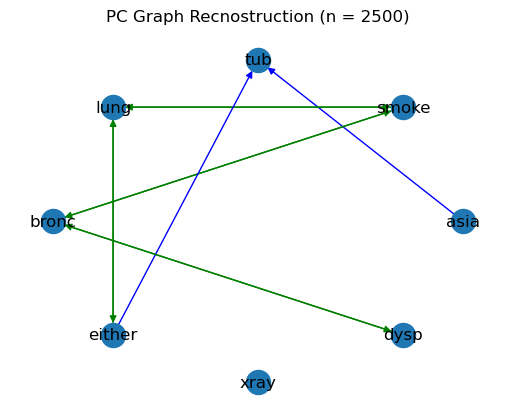


PC vs Ground Truth (Asia)
Adjacency precision: 1.000  (correct 6 / predicted 6)
Adjacency recall:    0.750  (correct 6 / true 8)
Arrowhead precision: 0.500  (correct 1 / predicted 2)
Arrowhead recall:    0.125  (correct 1 / true 8)
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0 -1 -1  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0 -1  0  0  0 -1  0  0]
 [ 0 -1  0  0  0  0  0 -1]
 [ 0  0  1  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0]]
Green: undirected; Blue: directed; Red: bi-directed



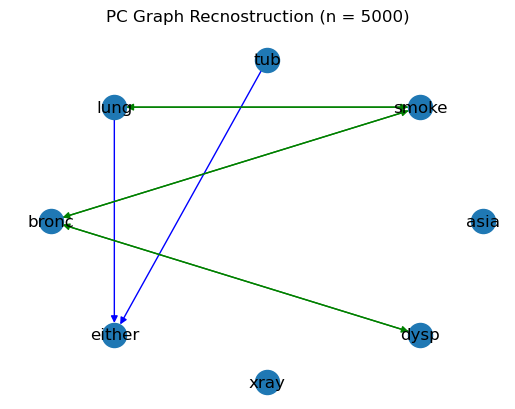


PC vs Ground Truth (Asia)
Adjacency precision: 1.000  (correct 5 / predicted 5)
Adjacency recall:    0.625  (correct 5 / true 8)
Arrowhead precision: 1.000  (correct 2 / predicted 2)
Arrowhead recall:    0.250  (correct 2 / true 8)


In [108]:

# Visualising reconstructed PC models + Evaluation
for i in range(len(cgs_models)):

    cg = cgs_models[i]


    print(cg.G.graph)

    Gnx = cg.to_nx_graph()
    plt.title(f"PC Graph Recnostruction (n = {sample_sizes[i]})")
    cg.draw_nx_graph(skel=False)
    



    node_names = df.columns.tolist()
    evaluate_graph(GT, cg.G, node_names, name="PC vs Ground Truth (Asia)")


In [109]:

# Fitting GES WITH ASIA



# sample_sizes = [100,1000,5000]



G_models = []


for sample_size in sample_sizes:
    

    df_subset = df.sample(n=sample_size, random_state=42).copy()


    X = df_subset.to_numpy().astype(int)

    record =  ges(X)  
    G = record["G"]
    

    G_models.append(G)



[[ 0  0 -1  0  0  0  0  0]
 [ 0  0  0  0 -1  1  0  0]
 [-1  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0 -1  0 -1]
 [ 0  1  0  0  0  0  0 -1]
 [ 0 -1  1  1  0  0 -1  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  1  1  0  0  0]]


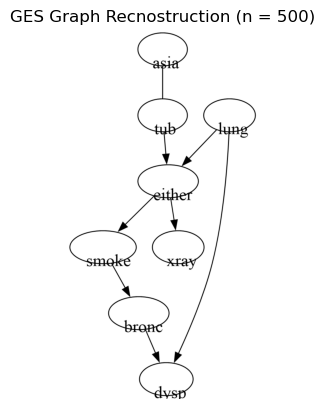


GES vs Ground Truth (Asia)
Adjacency precision: 0.750  (correct 6 / predicted 8)
Adjacency recall:    0.750  (correct 6 / true 8)
Arrowhead precision: 0.714  (correct 5 / predicted 7)
Arrowhead recall:    0.625  (correct 5 / true 8)
[[ 0  0 -1  0  0  0  0  0]
 [ 0  0  0  1  1  0  0  0]
 [-1  0  0  0  0 -1  0  0]
 [ 0 -1  0  0  0 -1  0  0]
 [ 0 -1  0  0  0  0  0 -1]
 [ 0  0  1  1  0  0 -1 -1]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  1  1  0  0]]


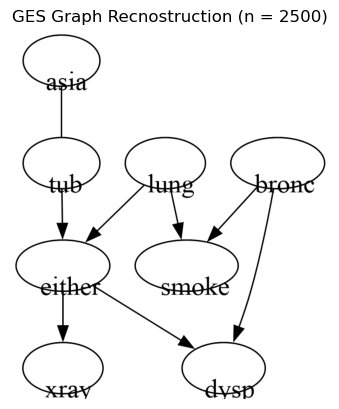


GES vs Ground Truth (Asia)
Adjacency precision: 1.000  (correct 8 / predicted 8)
Adjacency recall:    1.000  (correct 8 / true 8)
Arrowhead precision: 0.714  (correct 5 / predicted 7)
Arrowhead recall:    0.625  (correct 5 / true 8)
[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0 -1 -1  0  0  0]
 [ 0  0  0  0  0 -1  0  0]
 [ 0 -1  0  0  0 -1  0  0]
 [ 0 -1  0  0  0  0  0 -1]
 [ 0  0  1  1  0  0 -1 -1]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  1  1  0  0]]


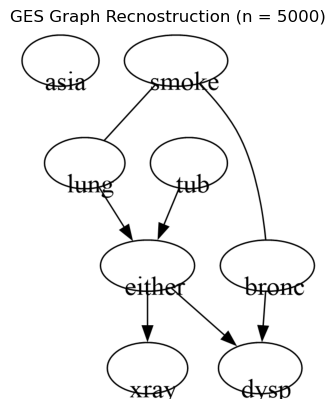


GES vs Ground Truth (Asia)
Adjacency precision: 1.000  (correct 7 / predicted 7)
Adjacency recall:    0.875  (correct 7 / true 8)
Arrowhead precision: 1.000  (correct 5 / predicted 5)
Arrowhead recall:    0.625  (correct 5 / true 8)


In [110]:
# Visualising and evaluating GES models on Asia dataset







for i in range(len(G_models)):


    G = G_models[i]

    print(G.graph)


    # visualising reconstruction
    labels = df.columns.tolist()
    pyd = GraphUtils.to_pydot(G,labels=labels)
    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.title(f"GES Graph Recnostruction (n = {sample_sizes[i]})")
    plt.imshow(img)
    plt.show()



    # evaluating reconstructed models
    evaluate_graph(GT, G, node_names, name="GES vs Ground Truth (Asia)")

## Cancer Dataset 

Ground truth nodes: ['Pollution', 'Smoker', 'Cancer', 'Xray', 'Dyspnoea']

Ground truth directed edges:
Pollution -> Cancer
Smoker -> Cancer
Cancer -> Xray
Cancer -> Dyspnoea


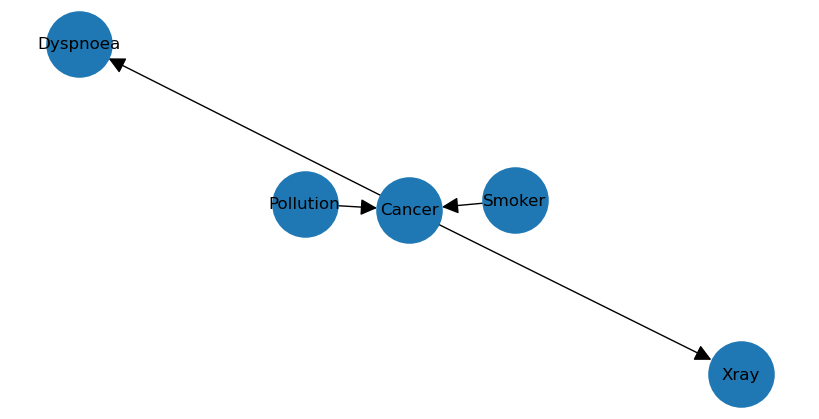

In [111]:
# load the built-in Cancer Bayesian network as the ground truth
model = get_example_model("cancer")

# extract its directed structure
gt_nodes = list(model.nodes())
gt_edges = list(model.edges())   

print("Ground truth nodes:", gt_nodes)
print("\nGround truth directed edges:")
for u, v in gt_edges:
    print(f"{u} -> {v}")

# we build a directed NetworkX graph
GT = nx.DiGraph()
GT.add_nodes_from(gt_nodes)
GT.add_edges_from(gt_edges)

#  draw 
pos = nx.spring_layout(GT, seed=7)

plt.figure(figsize=(8, 4))
nx.draw(GT, pos,
        with_labels=True,
        node_size=2200,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=25)

plt.axis("off")
plt.show()



In [112]:

# Creating Cancer dataset and PC algorithm

#sample size = [5000, 10000, 20000]

model = get_example_model("cancer")
sample_sizes = [5000, 20000]

cgs_models = []
pc_dfs = []   

for sample_size in sample_sizes:
    
    sampler = BayesianModelSampling(model)
    df = sampler.forward_sample(size=sample_size, seed=42)

    #encoding
    df_num = df.copy()
    for c in df_num.columns:
        df_num[c] = pd.Categorical(df_num[c]).codes

    X = df_num.to_numpy().astype(int)

    cg = pc(data=X,
            alpha=0.05,
            indep_test=chisq,
            stable=True,
            uc_rule=0,
            verbose=False,
            node_names=df.columns.tolist())

    cgs_models.append(cg)
    pc_dfs.append(df)




  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nikit\anaconda3\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nikit\anaconda3\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


  0%|          | 0/5 [00:00<?, ?it/s]

[[ 0  0 -1  0  0]
 [ 0  0 -1  0  0]
 [ 1  1  0  1  1]
 [ 0  0 -1  0  0]
 [ 0  0 -1  0  0]]
Green: undirected; Blue: directed; Red: bi-directed



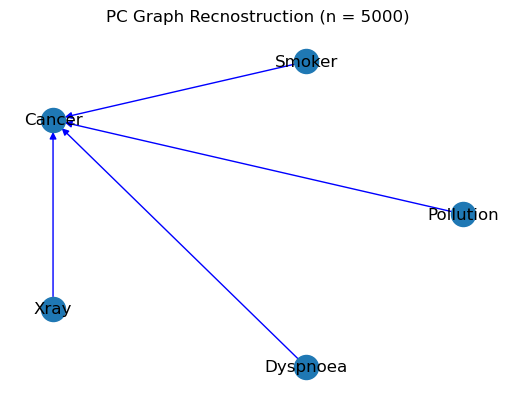


PC vs Ground Truth (Cancer)
Adjacency precision: 1.000  (correct 4 / predicted 4)
Adjacency recall:    1.000  (correct 4 / true 4)
Arrowhead precision: 0.500  (correct 2 / predicted 4)
Arrowhead recall:    0.500  (correct 2 / true 4)
[[ 0  0 -1  0  0]
 [ 0  0 -1  0  0]
 [ 1  1  0  1  1]
 [ 0  0 -1  0  0]
 [ 0  0 -1  0  0]]
Green: undirected; Blue: directed; Red: bi-directed



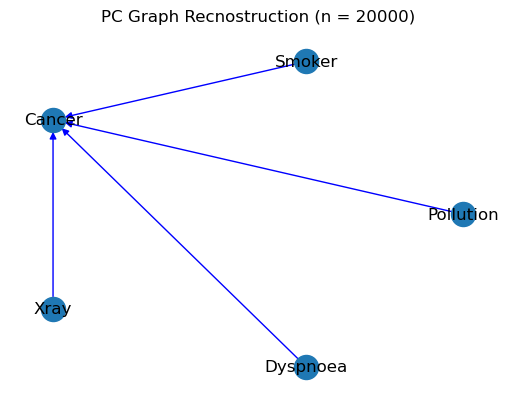


PC vs Ground Truth (Cancer)
Adjacency precision: 1.000  (correct 4 / predicted 4)
Adjacency recall:    1.000  (correct 4 / true 4)
Arrowhead precision: 0.500  (correct 2 / predicted 4)
Arrowhead recall:    0.500  (correct 2 / true 4)


In [113]:
# Visualising reconstructed PC models + Evaluation
for i in range(len(cgs_models)):

    cg = cgs_models[i]


    print(cg.G.graph)

    Gnx = cg.to_nx_graph()
    plt.title(f"PC Graph Recnostruction (n = {sample_sizes[i]})")
    cg.draw_nx_graph(skel=False)
    



    node_names = df.columns.tolist()
    evaluate_graph(GT, cg.G, node_names, name="PC vs Ground Truth (Cancer)")



In [114]:
# Fitting GES WITH CANCER

# sample_sizes = [5000,10000,20000]

G_models = []
ges_dfs = []  

for sample_size in sample_sizes:
    sampler = BayesianModelSampling(model)
    df = sampler.forward_sample(size=sample_size, seed=42)

    df_num = df.copy()
    for c in df_num.columns:
        df_num[c] = pd.Categorical(df_num[c]).codes

    X = df_num.to_numpy().astype(int)

    record = ges(X)
    G = record["G"]

    G_models.append(G)
    ges_dfs.append(df)


  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nikit\anaconda3\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


  0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nikit\anaconda3\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)



GES GRAPH MATRIX:
[[ 0  0  0  0  0]
 [ 0  0 -1  0  0]
 [ 0  1  0  1 -1]
 [ 0  0 -1  0  0]
 [ 0  0  1  0  0]]


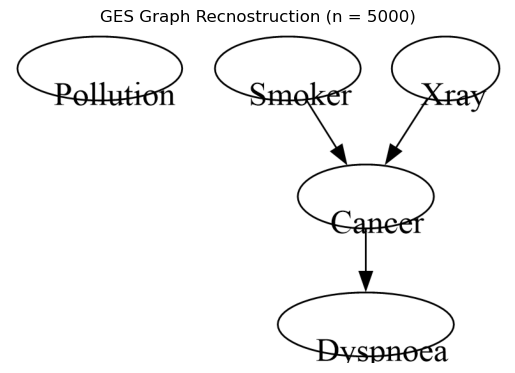


GES vs Ground Truth (Cancer) | n=5000
Adjacency precision: 1.000  (correct 3 / predicted 3)
Adjacency recall:    0.750  (correct 3 / true 4)
Arrowhead precision: 0.667  (correct 2 / predicted 3)
Arrowhead recall:    0.500  (correct 2 / true 4)

GES GRAPH MATRIX:
[[ 0  0 -1  0  0]
 [ 0  0 -1  0  0]
 [ 1  1  0 -1 -1]
 [ 0  0  1  0  0]
 [ 0  0  1  0  0]]


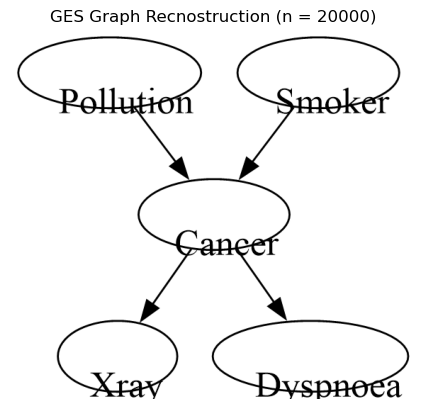


GES vs Ground Truth (Cancer) | n=20000
Adjacency precision: 1.000  (correct 4 / predicted 4)
Adjacency recall:    1.000  (correct 4 / true 4)
Arrowhead precision: 1.000  (correct 4 / predicted 4)
Arrowhead recall:    1.000  (correct 4 / true 4)


In [115]:
# Visualising and evaluating GES models on Cancer dataset

for i, G in enumerate(G_models):
    node_names = ges_dfs[i].columns.tolist()

    print("\nGES GRAPH MATRIX:")
    print(G.graph)

    pyd = GraphUtils.to_pydot(G, labels=node_names)
    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format="png")

    plt.axis("off")
    plt.title(f"GES Graph Recnostruction (n = {sample_sizes[i]})")

    plt.imshow(img)
    plt.show()

    evaluate_graph(GT, G, node_names, name=f"GES vs Ground Truth (Cancer) | n={len(ges_dfs[i])}")
